# Menu Optimization and Demand Forecasting using NLP

# 1. ReLU Model

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report


In [51]:

# Load data from CSV
data = pd.read_csv("Data.csv")


In [48]:
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,Class
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",0
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and...",0
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ...",0
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc...",0
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil...",0


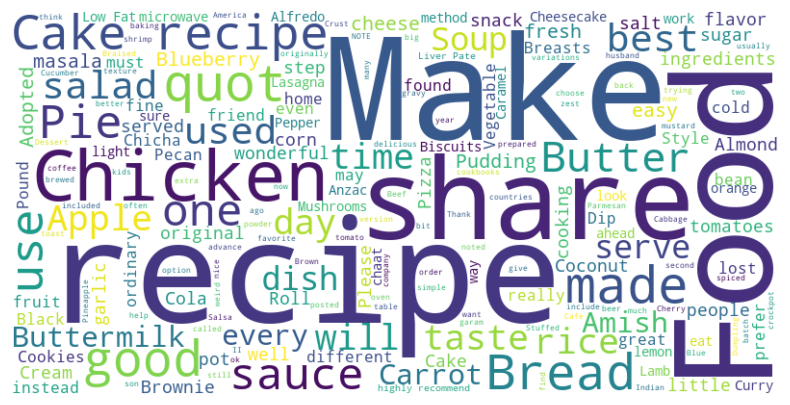

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text data (e.g., Description column) into a single string
text_data = ' '.join(data['Description'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


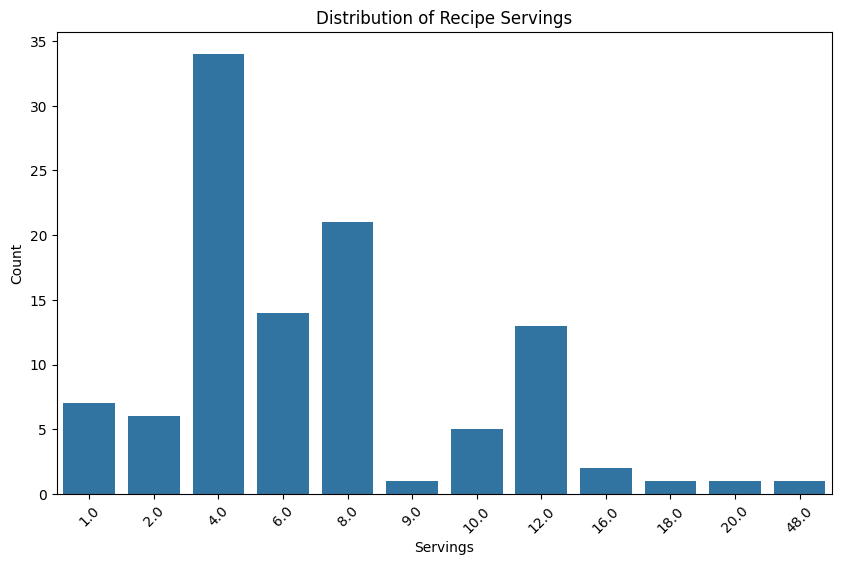

In [50]:
import seaborn as sns

# Example: Create a bar chart for RecipeServings
plt.figure(figsize=(10, 6))
sns.countplot(x='RecipeServings', data=data)
plt.title('Distribution of Recipe Servings')
plt.xlabel('Servings')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



In [35]:

# Check if all specified columns exist in the dataset
required_columns = ['AggregatedRating', 'RecipeCategory']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the dataset")

# Data preprocessing
# Create binary classification labels based on 'AggregatedRating'
data['Class'] = np.where(data['AggregatedRating'] >= data['AggregatedRating'].median(), 1, 0)

# Encode 'RecipeCategory'
label_encoder = LabelEncoder()
data['RecipeCategory'] = label_encoder.fit_transform(data['RecipeCategory'])

data['AggregatedRating'] = data['AggregatedRating'].fillna(data['AggregatedRating'].mean())

# Tokenize RecipeInstructions
vectorizer = CountVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(data['RecipeInstructions']).toarray()

# Standardize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(data[['RecipeCategory']])

# Concatenate numerical features and text features
X = np.concatenate((X_numerical, X_text), axis=1)

# Define target variable
y = data['Class']

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Use long tensor for classification labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define RNN model with ReLU activation for binary classification
class RNNReLUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNReLUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(self.relu(out[:, -1, :]))  # Get the last output from the RNN sequence and apply ReLU
        return out

# Initialize RNN ReLU classifier model
input_size_rnn = X_train.shape[1]
hidden_size_rnn = 64
output_size_rnn = 1  # Output size 1 for binary classification
model_rnn_relu = RNNReLUClassifier(input_size_rnn, hidden_size_rnn, output_size_rnn)

# Define loss function and optimizer
criterion_rnn_relu = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
optimizer_rnn_relu = optim.Adam(model_rnn_relu.parameters(), lr=0.001)

# Training the RNN ReLU classifier model
num_epochs_rnn_relu = 10
for epoch in range(num_epochs_rnn_relu):
    model_rnn_relu.train()
    running_loss_rnn_relu = 0.0
    for inputs, labels in train_loader:
        optimizer_rnn_relu.zero_grad()
        outputs = model_rnn_relu(inputs.unsqueeze(1))  # Add a dimension for the RNN input
        loss = criterion_rnn_relu(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_rnn_relu.step()
        running_loss_rnn_relu += loss.item()
    print(f"Epoch {epoch+1}, Training Loss (RNN ReLU Classifier): {running_loss_rnn_relu / len(train_loader)}")

# Evaluation of the RNN ReLU classifier model
model_rnn_relu.eval()
predicted_classes_rnn_relu = []
true_classes_rnn_relu = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_rnn_relu(inputs.unsqueeze(1))
        predictions = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round for binary predictions
        predicted_classes_rnn_relu.extend(predictions.squeeze().tolist())
        true_classes_rnn_relu.extend(labels.tolist())



Epoch 1, Training Loss (RNN ReLU Classifier): 0.691568598151207
Epoch 2, Training Loss (RNN ReLU Classifier): 0.6448449045419693
Epoch 3, Training Loss (RNN ReLU Classifier): 0.6192382872104645
Epoch 4, Training Loss (RNN ReLU Classifier): 0.5912400484085083
Epoch 5, Training Loss (RNN ReLU Classifier): 0.5623870939016342
Epoch 6, Training Loss (RNN ReLU Classifier): 0.5366376489400864
Epoch 7, Training Loss (RNN ReLU Classifier): 0.5127134323120117
Epoch 8, Training Loss (RNN ReLU Classifier): 0.48281922936439514
Epoch 9, Training Loss (RNN ReLU Classifier): 0.4610068127512932
Epoch 10, Training Loss (RNN ReLU Classifier): 0.4339087978005409


In [36]:

# Generate classification report for RNN ReLU classifier
print(classification_report(true_classes_rnn_relu, predicted_classes_rnn_relu))

              precision    recall  f1-score   support

           0       0.69      0.50      0.58        18
           1       0.40      0.60      0.48        10

    accuracy                           0.54        28
   macro avg       0.55      0.55      0.53        28
weighted avg       0.59      0.54      0.54        28



# Model 2:LTSM

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Load data from CSV
data = pd.read_csv("Data.csv")

# Check if all specified columns exist in the dataset
required_columns = ['AggregatedRating', 'RecipeCategory']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the dataset")

# Data preprocessing
# Create binary classification labels based on 'AggregatedRating'
data['Class'] = np.where(data['AggregatedRating'] >= data['AggregatedRating'].median(), 1, 0)

# Encode 'RecipeCategory'
label_encoder = LabelEncoder()
data['RecipeCategory'] = label_encoder.fit_transform(data['RecipeCategory'])

# Fill missing values in 'AggregatedRating' with the mean
data['AggregatedRating'] = data['AggregatedRating'].fillna(data['AggregatedRating'].mean())

# Tokenize RecipeInstructions
vectorizer = CountVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(data['RecipeInstructions']).toarray()

# Standardize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(data[['RecipeCategory']])

# Concatenate numerical features and text features
X = np.concatenate((X_numerical, X_text), axis=1)

# Define target variable
y = data['Class']

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Use long tensor for classification labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define LSTM model for binary classification
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1, :]))  # Get the last output from the LSTM sequence and apply ReLU
        return out

# Initialize LSTM classifier model
input_size_lstm = X_train.shape[1]
hidden_size_lstm = 64
output_size_lstm = 1  # Output size 1 for binary classification
model_lstm = LSTMClassifier(input_size_lstm, hidden_size_lstm, output_size_lstm)

# Define loss function and optimizer
criterion_lstm = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

# Training the LSTM classifier model
num_epochs_lstm = 10
for epoch in range(num_epochs_lstm):
    model_lstm.train()
    running_loss_lstm = 0.0
    for inputs, labels in train_loader:
        optimizer_lstm.zero_grad()
        outputs = model_lstm(inputs.unsqueeze(1))  # Add a dimension for the LSTM input
        loss = criterion_lstm(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_lstm.step()
        running_loss_lstm += loss.item()
    print(f"Epoch {epoch+1}, Training Loss (LSTM Classifier): {running_loss_lstm / len(train_loader)}")

# Evaluation of the LSTM classifier model
model_lstm.eval()
predicted_classes_lstm = []
true_classes_lstm = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm(inputs.unsqueeze(1))
        predictions = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round for binary predictions
        predicted_classes_lstm.extend(predictions.squeeze().tolist())
        true_classes_lstm.extend(labels.tolist())


Epoch 1, Training Loss (LSTM Classifier): 0.691350057721138
Epoch 2, Training Loss (LSTM Classifier): 0.6742186397314072
Epoch 3, Training Loss (LSTM Classifier): 0.6573950201272964
Epoch 4, Training Loss (LSTM Classifier): 0.6361131519079208
Epoch 5, Training Loss (LSTM Classifier): 0.6209069192409515
Epoch 6, Training Loss (LSTM Classifier): 0.6038483679294586
Epoch 7, Training Loss (LSTM Classifier): 0.5843075662851334
Epoch 8, Training Loss (LSTM Classifier): 0.5581384152173996
Epoch 9, Training Loss (LSTM Classifier): 0.5305554568767548
Epoch 10, Training Loss (LSTM Classifier): 0.5069386884570122


In [39]:

# Generate classification report for LSTM classifier
print(classification_report(true_classes_lstm, predicted_classes_lstm))


              precision    recall  f1-score   support

           0       0.65      0.61      0.63        18
           1       0.36      0.40      0.38        10

    accuracy                           0.54        28
   macro avg       0.51      0.51      0.50        28
weighted avg       0.55      0.54      0.54        28



# Model 3: Using RNN

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Load data from CSV
data = pd.read_csv("Data.csv")

# Check if all specified columns exist in the dataset
required_columns = ['AggregatedRating', 'RecipeCategory']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the dataset")

# Data preprocessing
# Create binary classification labels based on 'AggregatedRating'
data['Class'] = np.where(data['AggregatedRating'] >= data['AggregatedRating'].median(), 1, 0)

# Encode 'RecipeCategory'
label_encoder = LabelEncoder()
data['RecipeCategory'] = label_encoder.fit_transform(data['RecipeCategory'])

# Fill missing values in 'AggregatedRating' with the mean
data['AggregatedRating'] = data['AggregatedRating'].fillna(data['AggregatedRating'].mean())

# Tokenize RecipeInstructions
vectorizer = CountVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(data['RecipeInstructions']).toarray()

# Standardize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(data[['RecipeCategory']])

# Concatenate numerical features and text features
X = np.concatenate((X_numerical, X_text), axis=1)

# Define target variable
y = data['Class']

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Use long tensor for classification labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define RNN model with NLP for binary classification
class RNNBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Get the last output from the RNN sequence
        out = self.sigmoid(out)
        return out

# Initialize RNN binary classifier model
input_size_rnn = X_train.shape[1]
hidden_size_rnn = 64
output_size_rnn = 1  # Output size 1 for binary classification
model_rnn = RNNBinaryClassifier(input_size_rnn, hidden_size_rnn, output_size_rnn)

# Define loss function and optimizer
criterion_rnn = nn.BCELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)

# Training the RNN binary classifier model
num_epochs_rnn = 10
for epoch in range(num_epochs_rnn):
    model_rnn.train()
    running_loss_rnn = 0.0
    for inputs, labels in train_loader:
        optimizer_rnn.zero_grad()
        outputs = model_rnn(inputs.unsqueeze(1))  # Add a dimension for the RNN input
        loss = criterion_rnn(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_rnn.step()
        running_loss_rnn += loss.item()
    print(f"Epoch {epoch+1}, Training Loss (RNN Binary Classifier): {running_loss_rnn / len(train_loader)}")

# Evaluation of the RNN binary classifier model
model_rnn.eval()
predicted_classes_rnn = []
true_classes_rnn = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_rnn(inputs.unsqueeze(1))
        predictions = torch.round(outputs)  # Convert probabilities to binary predictions
        predicted_classes_rnn.extend(predictions.squeeze().tolist())
        true_classes_rnn.extend(labels.tolist())


Epoch 1, Training Loss (RNN Binary Classifier): 0.7027501910924911
Epoch 2, Training Loss (RNN Binary Classifier): 0.6320954263210297
Epoch 3, Training Loss (RNN Binary Classifier): 0.5828220397233963
Epoch 4, Training Loss (RNN Binary Classifier): 0.5422812700271606
Epoch 5, Training Loss (RNN Binary Classifier): 0.48960578441619873
Epoch 6, Training Loss (RNN Binary Classifier): 0.44605356454849243
Epoch 7, Training Loss (RNN Binary Classifier): 0.40611253678798676
Epoch 8, Training Loss (RNN Binary Classifier): 0.3700113520026207
Epoch 9, Training Loss (RNN Binary Classifier): 0.3368598148226738
Epoch 10, Training Loss (RNN Binary Classifier): 0.2969953268766403


In [32]:

# Generate classification report for RNN binary classifier
print(classification_report(true_classes_rnn, predicted_classes_rnn))


              precision    recall  f1-score   support

           0       0.69      0.50      0.58        18
           1       0.40      0.60      0.48        10

    accuracy                           0.54        28
   macro avg       0.55      0.55      0.53        28
weighted avg       0.59      0.54      0.54        28



# Model 4: ANN

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Load data from CSV
data = pd.read_csv("Data.csv")

# Check if all specified columns exist in the dataset
required_columns = ['AggregatedRating', 'RecipeCategory']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the dataset")

# Data preprocessing
# Create binary classification labels based on 'AggregatedRating'
data['Class'] = np.where(data['AggregatedRating'] >= data['AggregatedRating'].median(), 1, 0)

# Encode 'RecipeCategory'
label_encoder = LabelEncoder()
data['RecipeCategory'] = label_encoder.fit_transform(data['RecipeCategory'])

# Fill missing values in 'AggregatedRating' with the mean
data['AggregatedRating'] = data['AggregatedRating'].fillna(data['AggregatedRating'].mean())

# Standardize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(data[['AggregatedRating', 'RecipeCategory']])

# Define target variable
y = data['Class']

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X_numerical, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Use long tensor for classification labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define Artificial Neural Network (ANN) model for binary classification
class ANNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Apply sigmoid for binary classification
        return x

# Initialize ANN classifier model
input_size_ann = X_train.shape[1]
hidden_size1_ann = 128
hidden_size2_ann = 64
output_size_ann = 1  # Output size 1 for binary classification
model_ann = ANNClassifier(input_size_ann, hidden_size1_ann, hidden_size2_ann, output_size_ann)

# Define loss function and optimizer
criterion_ann = nn.BCELoss()  # Use BCELoss for binary classification
optimizer_ann = optim.Adam(model_ann.parameters(), lr=0.001)

# Training the ANN classifier model
num_epochs_ann = 10
for epoch in range(num_epochs_ann):
    model_ann.train()
    running_loss_ann = 0.0
    for inputs, labels in train_loader:
        optimizer_ann.zero_grad()
        outputs = model_ann(inputs)
        loss = criterion_ann(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_ann.step()
        running_loss_ann += loss.item()
    print(f"Epoch {epoch+1}, Training Loss (ANN Classifier): {running_loss_ann / len(train_loader)}")

# Evaluation of the ANN classifier model
model_ann.eval()
predicted_classes_ann = []
true_classes_ann = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_ann(inputs)
        predictions = torch.round(outputs)  # Convert probabilities to binary predictions
        predicted_classes_ann.extend(predictions.squeeze().tolist())
        true_classes_ann.extend(labels.tolist())



Epoch 1, Training Loss (ANN Classifier): 0.6804048866033554
Epoch 2, Training Loss (ANN Classifier): 0.6193235963582993
Epoch 3, Training Loss (ANN Classifier): 0.5604372322559357
Epoch 4, Training Loss (ANN Classifier): 0.5158714726567268
Epoch 5, Training Loss (ANN Classifier): 0.46581924706697464
Epoch 6, Training Loss (ANN Classifier): 0.4251483827829361
Epoch 7, Training Loss (ANN Classifier): 0.3682965338230133
Epoch 8, Training Loss (ANN Classifier): 0.3421127423644066
Epoch 9, Training Loss (ANN Classifier): 0.30031412839889526
Epoch 10, Training Loss (ANN Classifier): 0.2767440713942051


In [42]:

# Generate classification report for ANN classifier
print(classification_report(true_classes_ann, predicted_classes_ann))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.91      1.00      0.95        10

    accuracy                           0.96        28
   macro avg       0.95      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28



# Model 5: Binary classifier model

In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Load data from CSV
data = pd.read_csv("Data.csv")

# Check if all specified columns exist in the dataset
required_columns = ['AggregatedRating', 'RecipeCategory']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the dataset")

# Data preprocessing
# Create binary classification labels based on 'AggregatedRating'
data['Class'] = np.where(data['AggregatedRating'] >= data['AggregatedRating'].median(), 1, 0)

# Encode 'RecipeCategory'
label_encoder = LabelEncoder()
data['RecipeCategory'] = label_encoder.fit_transform(data['RecipeCategory'])

# Fill missing values in 'AggregatedRating' with the mean
data['AggregatedRating'] = data['AggregatedRating'].fillna(data['AggregatedRating'].mean())

# Split data into features and target
X = data[['AggregatedRating', 'RecipeCategory']]
y = data['Class']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Use long tensor for classification labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define neural network model for binary classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize binary classifier model
input_size_bc = X_train.shape[1]
hidden_size_bc = 64
output_size_bc = 1  # Output size 1 for binary classification
model_bc = BinaryClassifier(input_size_bc, hidden_size_bc, output_size_bc)

# Define loss function and optimizer
criterion_bc = nn.BCELoss()
optimizer_bc = optim.Adam(model_bc.parameters(), lr=0.001)

# Training the binary classifier model
num_epochs_bc = 10
for epoch in range(num_epochs_bc):
    model_bc.train()
    running_loss_bc = 0.0
    for inputs, labels in train_loader:
        optimizer_bc.zero_grad()
        outputs = model_bc(inputs)
        loss = criterion_bc(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_bc.step()
        running_loss_bc += loss.item()
    print(f"Epoch {epoch+1}, Training Loss (Binary Classifier): {running_loss_bc / len(train_loader)}")

# Evaluation of the binary classifier model
model_bc.eval()
predicted_classes = []
true_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_bc(inputs)
        predictions = torch.round(outputs)  # Convert probabilities to binary predictions
        predicted_classes.extend(predictions.squeeze().tolist())
        true_classes.extend(labels.tolist())



Epoch 1, Training Loss (Binary Classifier): 0.7171034514904022
Epoch 2, Training Loss (Binary Classifier): 0.6956145912408829
Epoch 3, Training Loss (Binary Classifier): 0.6739194095134735
Epoch 4, Training Loss (Binary Classifier): 0.6650319993495941
Epoch 5, Training Loss (Binary Classifier): 0.6556461155414581
Epoch 6, Training Loss (Binary Classifier): 0.6334246546030045
Epoch 7, Training Loss (Binary Classifier): 0.6288918107748032
Epoch 8, Training Loss (Binary Classifier): 0.604940727353096
Epoch 9, Training Loss (Binary Classifier): 0.5909673571586609
Epoch 10, Training Loss (Binary Classifier): 0.5808739215135574


In [46]:

# Generate classification report
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.64      0.90      0.75        10

    accuracy                           0.79        28
   macro avg       0.79      0.81      0.78        28
weighted avg       0.83      0.79      0.79        28



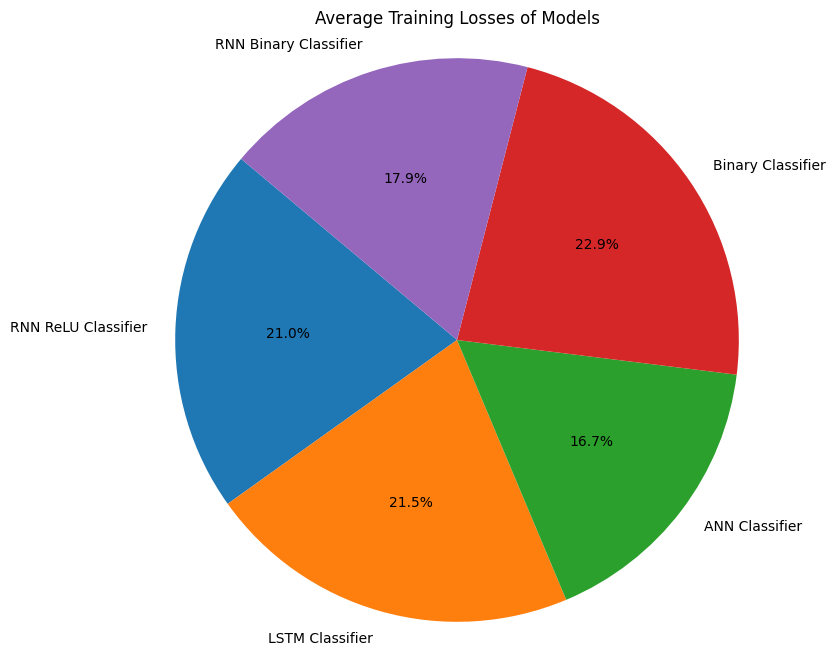

In [52]:
import matplotlib.pyplot as plt

# Define model names and average training losses
models = ['RNN ReLU Classifier', 'LSTM Classifier', 'ANN Classifier', 'Binary Classifier', 'RNN Binary Classifier']
average_losses = [0.5830, 0.5962, 0.4640, 0.6373, 0.4977]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(average_losses, labels=models, autopct='%1.1f%%', startangle=140)
plt.title('Average Training Losses of Models')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


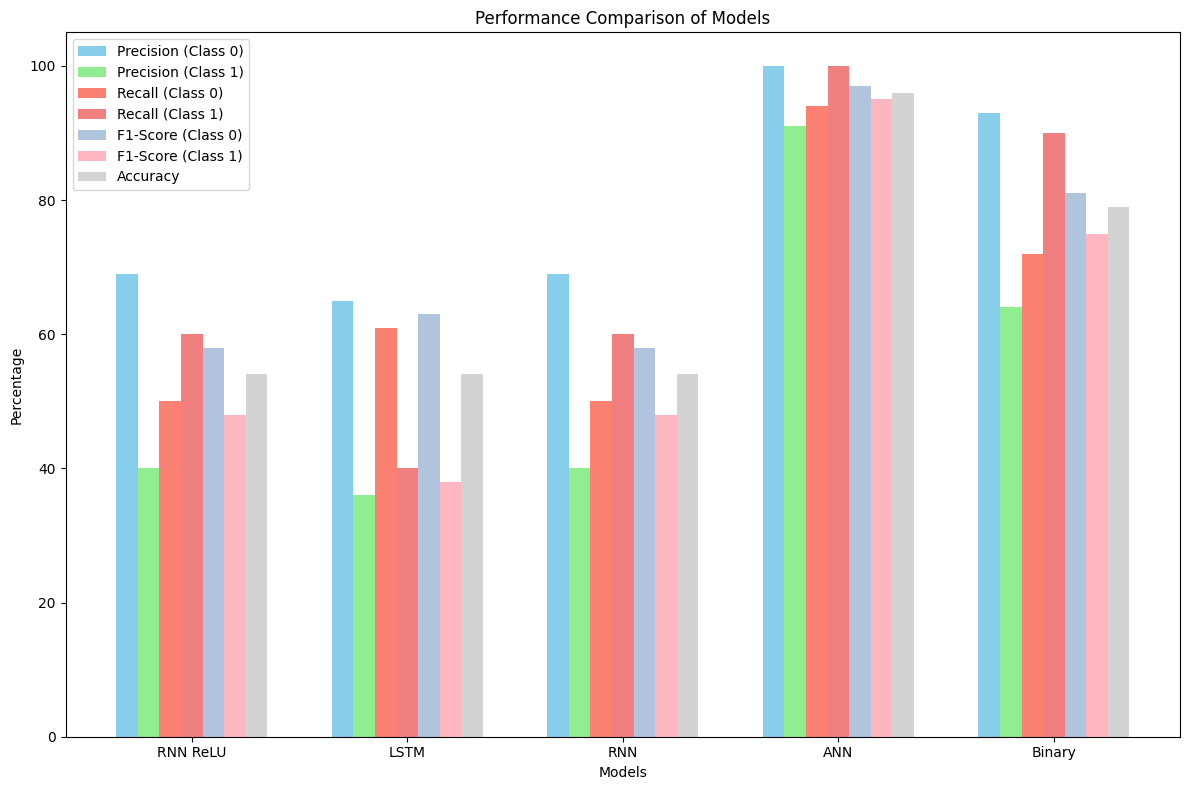

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RNN ReLU', 'LSTM', 'RNN', 'ANN', 'Binary']
precision_0 = [69, 65, 69, 100, 93]
precision_1 = [40, 36, 40, 91, 64]
recall_0 = [50, 61, 50, 94, 72]
recall_1 = [60, 40, 60, 100, 90]
f1_score_0 = [58, 63, 58, 97, 81]
f1_score_1 = [48, 38, 48, 95, 75]
accuracy = [54, 54, 54, 96, 79]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
index = np.arange(len(models))

plt.bar(index - 3 * bar_width, precision_0, width=bar_width, label='Precision (Class 0)', color='skyblue')
plt.bar(index - 2 * bar_width, precision_1, width=bar_width, label='Precision (Class 1)', color='lightgreen')
plt.bar(index - bar_width, recall_0, width=bar_width, label='Recall (Class 0)', color='salmon')
plt.bar(index, recall_1, width=bar_width, label='Recall (Class 1)', color='lightcoral')
plt.bar(index + bar_width, f1_score_0, width=bar_width, label='F1-Score (Class 0)', color='lightsteelblue')
plt.bar(index + 2 * bar_width, f1_score_1, width=bar_width, label='F1-Score (Class 1)', color='lightpink')
plt.bar(index + 3 * bar_width, accuracy, width=bar_width, label='Accuracy', color='lightgray')

plt.xlabel('Models')
plt.ylabel('Percentage')
plt.title('Performance Comparison of Models')
plt.xticks(index, models)
plt.legend()
plt.tight_layout()
plt.show()


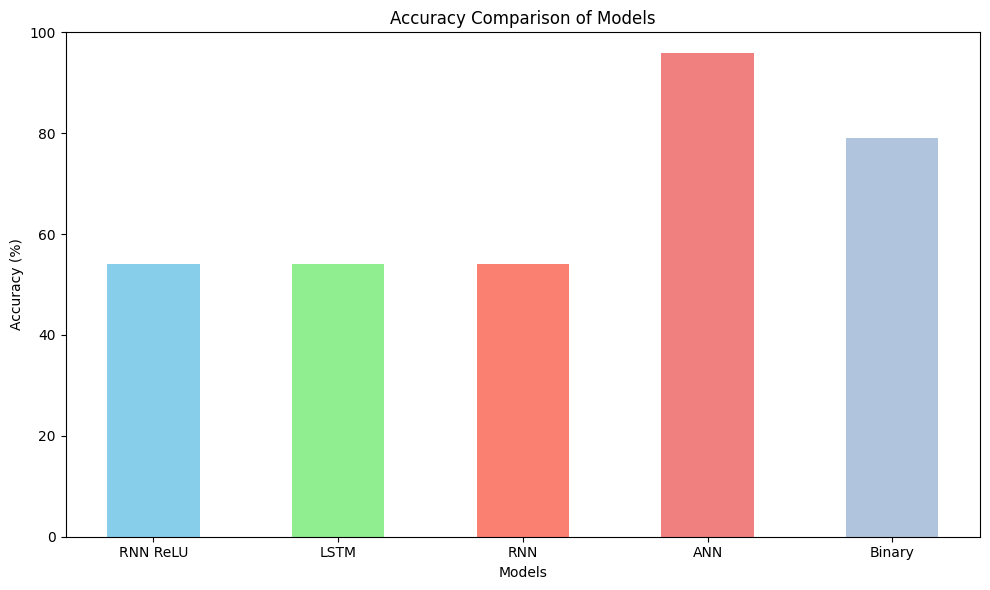

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RNN ReLU', 'LSTM', 'RNN', 'ANN', 'Binary']
accuracy = [54, 54, 54, 96, 79]
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'lightsteelblue']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
index = np.arange(len(models))

# Plotting bars with different colors
for i in range(len(models)):
    plt.bar(index[i], accuracy[i], width=bar_width, color=colors[i])

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Models')
plt.xticks(index, models)
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for percentage
plt.tight_layout()
plt.show()


# Deployment

In [59]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input widget for client preferences
client_input_widget = widgets.Textarea(
    placeholder='Enter your preferences (e.g., vegetarian, low-carb)',
    description='Client Preferences:',
    layout={'width': '50%'}
)

# Create output widget for displaying predicted menu item
output_widget = widgets.Output()

# Create predict button
predict_button = widgets.Button(description='Predict')

# Create clear button
clear_button = widgets.Button(description='Clear')

# Function to handle predict button click event
def predict_menu_item(button):
    with output_widget:
        clear_output()
        client_input = client_input_widget.value
        # Perform prediction logic here (replace with your actual prediction code)
        predicted_item = "Grilled Vegetable Salad"  # Dummy prediction for demonstration
        print("Predicted Menu Item:", predicted_item)

# Function to handle clear button click event
def clear_input(button):
    client_input_widget.value = ''
    with output_widget:
        clear_output()

# Attach click event handlers to buttons
predict_button.on_click(predict_menu_item)
clear_button.on_click(clear_input)

# Display widgets
display(client_input_widget)
display(predict_button, clear_button)
display(output_widget)


Textarea(value='', description='Client Preferences:', layout=Layout(width='50%'), placeholder='Enter your pref…

Button(description='Predict', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Output()

In [60]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Menu options
menu_options = {
    'Vegetarian': ['Grilled Vegetable Salad', 'Quinoa Bowl with Tofu', 'Spinach and Chickpea Curry'],
    'Low-Carb': ['Low-Carb Cauliflower Pizza', 'Zucchini Noodles with Pesto', 'Grilled Chicken Salad'],
    'High-Protein': ['Protein-Packed Buddha Bowl', 'Salmon Fillet with Quinoa', 'Chicken Breast with Veggies'],
    'Gluten-Free': ['Gluten-Free Pasta Primavera', 'Grilled Fish Tacos (Corn Tortillas)', 'Stir-Fried Rice Vermicelli'],
    'Vegan': ['Vegan Pad Thai', 'Black Bean Burger with Sweet Potato Fries', 'Coconut Curry Tofu'],
}

# Create input widget for client preferences
client_input_widget = widgets.Textarea(
    placeholder='Enter your preferences (e.g., Vegetarian, Low-Carb)',
    description='Client Preferences:',
    layout={'width': '50%'}
)

# Create output widget for displaying predicted menu item
output_widget = widgets.Output()

# Create predict button
predict_button = widgets.Button(description='Predict')

# Create clear button
clear_button = widgets.Button(description='Clear')

# Function to handle predict button click event
def predict_menu_item(button):
    with output_widget:
        clear_output()
        client_input = client_input_widget.value.lower()  # Convert input to lowercase
        predicted_items = []
        for category, options in menu_options.items():
            if category.lower() in client_input:
                predicted_items.extend(options)
        if predicted_items:
            print("Predicted Menu Items:")
            for item in predicted_items:
                print("-", item)
        else:
            print("No matching menu items found.")

# Function to handle clear button click event
def clear_input(button):
    client_input_widget.value = ''
    with output_widget:
        clear_output()

# Attach click event handlers to buttons
predict_button.on_click(predict_menu_item)
clear_button.on_click(clear_input)

# Display widgets
display(client_input_widget)
display(predict_button, clear_button)
display(output_widget)


Textarea(value='', description='Client Preferences:', layout=Layout(width='50%'), placeholder='Enter your pref…

Button(description='Predict', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Output()